In [ ]:
!pip install wikipedia
!pip install nxviz

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11680 sha256=ecf05d293473a4904e62ddffbbd03664a78b5d1b09b6f26d5e0ff67c01e5088d
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


In [ ]:
from operator import itemgetter
import networkx as nx
import wikipedia
import nxviz as nv
from nxviz import annotate, highlights
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import pandas as pd
import os

## 1 Creating graph

In [ ]:
def create_graph(args: dict) -> nx.DiGraph:

  todo_lst = [(0, SEED)] # The SEED is in the layer 0
  todo_set = set(SEED) # The SEED itself
  done_set = set() # Nothing is done yet

  g = nx.DiGraph()
  layer, page = todo_lst[0]

  if os.path.isfile('extract.txt'):
    file = open('extract.txt', 'w')
  else:
    file = open('extract.txt', 'x')

  while layer <2:
    # Remove the name page of the current page from the todo_lst,
    # and add it to the set of processed pages.
    # If the script encounters this page again, it will skip over it.
    del todo_lst[0]
    done_set.add(page)

    # Show progress
    file.write(f"{layer} {page}\n")

    # Attempt to download the selected page.
    try:
      wiki = wikipedia.page(page)
    except:
      layer, page = todo_lst[0]
      continue

    for link in wiki.links:
      link = link.title()
      if link not in STOPS and not link.startswith("List Of"):
        if link not in todo_set and link not in done_set:
          todo_lst.append((layer + 1, link))
          todo_set.add(link)
        g.add_edge(page, link)
    layer, page = todo_lst[0]

  # close the file
  file.close()

  return g

## 2 Preprocessing

In [ ]:
def preprocessing(g: nx.DiGraph) -> nx.DiGraph:
  # remove self loops
  g.remove_edges_from(nx.selfloop_edges(g))

  # identify duplicates like that: 'network' and 'networks'
  duplicates = [(node, node + "s")
                for node in g if node + "s" in g
              ]

  for dup in duplicates:
    # *dup is a technique named 'unpacking'
    g = nx.contracted_nodes(g, *dup, self_loops=False)

  if os.path.isfile('preprocessing.txt'):
    file2 = open('preprocessing.txt', 'w')
  else:
    file2 = open('preprocessing.txt', 'x')

  # print(duplicates)
  file2.write(f"{duplicates}")

  duplicates = [(x, y) for x, y in
                [(node, node.replace("-", " ")) for node in g]
                  if x != y and y in g]

  # print(duplicates)
  file2.write(f"{duplicates}")

  for dup in duplicates:
    g = nx.contracted_nodes(g, *dup, self_loops=False)

  # print(duplicates)
  file2.write(f"{duplicates}")

  # nx.contracted creates a new node/edge attribute called contraction
  # the value of the attribute is a dictionary, but GraphML
  # does not support dictionary attributes
  nx.set_node_attributes(g, 0,"contraction")
  nx.set_edge_attributes(g, 0,"contraction")

  file2.close()

  return g

## 3 Network Pruning

In [ ]:
def plot_histogram(g: nx.DiGraph):
  plt.style.use("default")
  # degree sequence
  degree_sequence = sorted([d for n, d in g.degree()], reverse=True)

  fig, ax = plt.subplots(1,2,figsize=(8,4))

  # all_data has information about degree_sequence and the width of each bin
  ax[0].hist(degree_sequence)
  ax[1].hist(degree_sequence,bins=[1,2,3,4,5,6,7,8,9,10])

  ax[0].set_title("Degree Histogram")
  ax[0].set_ylabel("Count")
  ax[0].set_xlabel("Degree")
  ax[0].set_ylim(0,15000)

  ax[1].set_title("Degree Histogram - Zoom")
  ax[1].set_ylabel("Count")
  ax[1].set_xlabel("Degree")
  ax[1].set_xlim(0,10)
  ax[1].set_ylim(0,15000)

  plt.tight_layout()
  plt.show()

In [ ]:
def pruning(g: nx.DiGraph):
  # checking the degree for each node
  plot_histogram(g)

  # filter nodes with degree greater than or equal to 2
  core = [node for node, deg in dict(g.degree()).items() if deg >= 2]

  # select a subgraph with 'core' nodes
  gsub = nx.subgraph(g, core)

  print("{} nodes, {} edges".format(len(gsub), nx.number_of_edges(gsub)))
  print("Nodes removed: {:.2f}%".format(100*(1 - 3296/13526)))
  print("Edges removed: {:.2f}%".format(100*(1 - 14494/24724)))
  print("Edges per nodes: {:.2f}".format(13526/3296))

  nx.write_graphml(gsub, "cna.graphml")

## 4 Exploring network

In [ ]:
def important_nodes(g: nx.DiGraph):
  top_indegree = sorted(dict(g.in_degree()).items(),
                        reverse=True, key=itemgetter(1))[:10]

  # writing in a file
  if os.path.isfile('important_nodes.txt'):
    file3 = open('important_nodes.txt', 'w')
  else:
    file3 = open('important_nodes.txt', 'x')

  file3.write("\n".join(map(lambda t: "{} {}".format(*reversed(t)), top_indegree)))
  file3.close()

  important_nodes = [node for node, _ in top_indegree]
  subgraph = g.subgraph(important_nodes)

  nx.write_graphml(subgraph, "subgraph.graphml")

## 4.1.1 Degree Centrality

In [ ]:
def nodes_in_degree(subgraph: nx.DiGraph):
  fig, ax = plt.subplots(1,1,figsize=(10,8))

  # layout position
  pos = nx.spring_layout(subgraph,seed=123456789,k=0.9)

  # Color of nodes based on in_degree
  color = [subgraph.in_degree(node) for node in subgraph.nodes()]

  # draw edges
  nx.draw_networkx_edges(subgraph,
                        pos=pos,
                        alpha=0.4, ax=ax)

  # draw nodes
  nodes = nx.draw_networkx_nodes(subgraph,
                  pos=pos,
                  node_color=color,
                  cmap=plt.cm.jet,ax=ax)

  # draw labels
  nx.draw_networkx_labels(subgraph, pos=pos,
                          font_color='Green', ax=ax)


  plt.axis("off")
  plt.colorbar(nodes)
  plt.savefig('degree.png', transparent=True,dpi=300)
  plt.show()

In [ ]:
def nodes_centrality_degree(subgraph: nx.DiGraph):
  # Plotando o grafo completo com base na centralidade de grau
  fig, ax = plt.subplots(1, 1, figsize=(10, 8))

  # Layout position
  pos = nx.spring_layout(subgraph, seed=123456789, k=0.9)

  # Color of nodes based on degree centrality
  color = list(dict(nx.degree_centrality(subgraph)).values())

  # Draw edges
  nx.draw_networkx_edges(subgraph, pos=pos, alpha=0.4, ax=ax)

  # Draw nodes
  nodes = nx.draw_networkx_nodes(subgraph, pos=pos, node_color=color, cmap=plt.cm.jet, ax=ax)

  # Draw labels
  nx.draw_networkx_labels(subgraph, pos=pos, font_color='Green', ax=ax)

  plt.axis("off")
  plt.colorbar(nodes)
  plt.savefig('degree_centrality_subgraph.png', transparent=True, dpi=300)
  plt.show()

In [ ]:
def degree(subgraph: nx.DiGraph):
  nodes_in_degree(subgraph)
  nodes_centrality_degree(subgraph)

## 4.1.2 Closeness Centrality

In [ ]:
def closeness(subgraph: nx.DiGraph):
  # the closeness centrality of network(subgraph)
  fig, ax = plt.subplots(1,1,figsize=(10,8))

  # layout position
  pos = nx.spring_layout(subgraph,seed=123456789,k=0.9)
  # color of nodes
  color = list(dict(nx.closeness_centrality(subgraph)).values())

  # draw edges
  nx.draw_networkx_edges(subgraph,
                        pos=pos,
                        alpha=0.4, ax=ax)

  # draw nodes
  nodes = nx.draw_networkx_nodes(subgraph,
                  pos=pos,
                  node_color=color,
                  cmap=plt.cm.jet,
                  ax=ax)

  # draw labels
  nx.draw_networkx_labels(subgraph, pos=pos,
                          font_color='green', ax=ax)


  plt.axis("off")
  plt.colorbar(nodes)
  plt.savefig('closeness_centrality.png', transparent=True,dpi=600)
  plt.show()

## 4.1.3 Betwenness Centrality

In [ ]:
def betwenness(subgraph: nx.DiGraph):
  # the betwenness centrality of network(subgraph)
  fig, ax = plt.subplots(1,1,figsize=(10,8))

  # layout position
  pos = nx.spring_layout(subgraph,seed=123456789,k=0.9)
  # color of nodes
  color = list(dict(nx.betweenness_centrality(subgraph)).values())

  # draw edges
  nx.draw_networkx_edges(subgraph,
                        pos=pos,
                        alpha=0.4, ax=ax)

  # draw nodes
  nodes = nx.draw_networkx_nodes(subgraph,
                  pos=pos,
                  node_color=color,
                  cmap=plt.cm.jet,
                  ax=ax)

  # draw labels
  nx.draw_networkx_labels(subgraph, pos=pos,
                          font_color='green', ax=ax)


  plt.axis("off")
  plt.colorbar(nodes)
  plt.savefig('betweenness_centrality.png', transparent=True,dpi=600)
  plt.show()

## 4.1.4 EigenVector Centrality

In [ ]:
def eigenvector(subgraph: nx.DiGraph):
  # the eigenvector centrality of network(subgraph)
  fig, ax = plt.subplots(1,1,figsize=(10,8))

  # layout position
  pos = nx.spring_layout(subgraph,seed=123456789,k=0.9)
  # color of nodes
  color = list(dict(nx.eigenvector_centrality(subgraph)).values())

  # draw edges
  nx.draw_networkx_edges(subgraph,
                        pos=pos,
                        alpha=0.4, ax=ax)

  # draw nodes
  nodes = nx.draw_networkx_nodes(subgraph,
                  pos=pos,
                  node_color=color,
                  cmap=plt.cm.jet,
                  ax=ax)

  # draw labels
  nx.draw_networkx_labels(subgraph, pos=pos,
                          font_color='green', ax=ax)


  plt.axis("off")
  plt.colorbar(nodes)
  plt.savefig('eigenvector_centrality.png', transparent=True,dpi=600)
  plt.show()

## 4.1.5 All together

In [ ]:
def all_togheter(subgraph: nx.DiGraph):
  fig, ax = plt.subplots(2,2,figsize=(10,8))

  # max value of metrics
  max_centrality = max([max([v for k, v in nx.eigenvector_centrality(subgraph).items()]),
                        max([v for k, v in nx.degree_centrality(subgraph).items()]),
                        max([v for k, v in nx.closeness_centrality(subgraph).items()]),
                        max([v for k, v in nx.betweenness_centrality(subgraph).items()])])

  # layout position
  pos = nx.spring_layout(subgraph,seed=123456789,k=0.9)

  # color of nodes
  color_degree = list(dict(nx.degree_centrality(subgraph)).values())
  color_closeness = list(dict(nx.closeness_centrality(subgraph)).values())
  color_betweenness = list(dict(nx.betweenness_centrality(subgraph)).values())
  color_eigenvector = list(dict(nx.eigenvector_centrality(subgraph)).values())

  #
  # draw edges
  #
  # degree centrality
  nx.draw_networkx_edges(subgraph,
                        pos=pos,
                        alpha=0.4, ax=ax[0,0])

  # closeness centrality
  nx.draw_networkx_edges(subgraph,
                        pos=pos,
                        alpha=0.4, ax=ax[0,1])

  # betweenness centrality
  nx.draw_networkx_edges(subgraph,
                        pos=pos,
                        alpha=0.4, ax=ax[1,0])

  # eigenvector centrality
  nx.draw_networkx_edges(subgraph,
                        pos=pos,
                        alpha=0.4, ax=ax[1,1])

  # draw nodes
  nodes = nx.draw_networkx_nodes(subgraph,
                  pos=pos,
                  node_color=color_degree,
                  cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                  ax=ax[0,0])
  nodes = nx.draw_networkx_nodes(subgraph,
                  pos=pos,
                  node_color=color_closeness,
                  cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                  ax=ax[0,1])
  nodes = nx.draw_networkx_nodes(subgraph,
                  pos=pos,
                  node_color=color_betweenness,
                  cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                  ax=ax[1,0])
  nodes = nx.draw_networkx_nodes(subgraph,
                  pos=pos,
                  node_color=color_eigenvector,
                  cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                  ax=ax[1,1])

  #
  # draw labels
  #
  nx.draw_networkx_labels(subgraph, pos=pos,
                          font_color='green', ax=ax[0,0])
  nx.draw_networkx_labels(subgraph, pos=pos,
                          font_color='green', ax=ax[0,1])
  nx.draw_networkx_labels(subgraph, pos=pos,
                          font_color='green', ax=ax[1,0])
  nx.draw_networkx_labels(subgraph, pos=pos,
                          font_color='green', ax=ax[1,1])

  # eliminate axis
  ax[0,0].axis("off")
  ax[1,0].axis("off")
  ax[0,1].axis("off")
  ax[1,1].axis("off")

  ax[0,0].set_title("Degree Centraliy")
  ax[0,1].set_title("Closeness Centraliy")
  ax[1,0].set_title("Betweenness Centraliy")
  ax[1,1].set_title("Eigenvector Centraliy")


  # Create an unique colorbar
  # reference: https://stackoverflow.com/questions/60848582/unique-colorbar-at-the-right-of-multiple-subplots
  plt.subplots_adjust(bottom=0., right=0.92, top=1.)
  cax = plt.axes([0.95, 0.3, 0.025, 0.4])
  sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=0, vmax=max_centrality))
  cbar=plt.colorbar(sm,cax)

  plt.savefig('alltogether.png', transparent=True,dpi=600,bbox_inches="tight")
  plt.show()

# 4.2 Centrality Distribution

## 4.2.1 PDF and CDF

In [ ]:
def degree_sequence(subgraph: nx.DiGraph):
  plt.style.use("default")
  # degree sequence
  degree_sequence = sorted([d for n, d in subgraph.degree()], reverse=True)

  fig, ax = plt.subplots(1,2,figsize=(8,6))

  # all_data has information about degree_sequence and the width of each bin
  all_data = ax[0].hist(degree_sequence,bins=7)
  ax[1].hist(degree_sequence,bins=7,density=True)

  ax[0].set_title("Degree Histogram")
  ax[0].set_ylabel("Count")
  ax[0].set_xlabel("Degree")

  ax[1].set_title("Probability Density Function")
  ax[1].set_ylabel("Probability")
  ax[1].set_xlabel("Degree")

  plt.tight_layout()
  plt.show()

In [ ]:
def pdf(subgraph: nx.DiGraph):
  plt.style.use("fivethirtyeight")

  degree_sequence = sorted([d for n, d in subgraph.degree()], reverse=True)

  fig, ax = plt.subplots(1,1,figsize=(10,8))

  sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
  ax2 = ax.twinx()
  sns.kdeplot(degree_sequence,color='r',label="Probability Density Function (PDF)",ax=ax2)

  # ask matplotlib for the plotted objects and their labels
  lines, labels = ax.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
  ax2.legend(lines + lines2, labels + labels2, loc=0)

  ax.grid(False)
  ax2.grid(False)
  ax.set_xlabel("Degree")
  ax2.set_ylabel("Probability")

  plt.savefig('probability_density_function.png', transparent=True,dpi=600,bbox_inches="tight")
  plt.show()

In [ ]:
def cdf(subgraph: nx.DiGraph):
  plt.style.use("fivethirtyeight")

  degree_sequence = sorted([d for n, d in subgraph.degree()], reverse=True)

  fig, ax = plt.subplots(1,1,figsize=(10,8))

  sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
  ax2 = ax.twinx()
  sns.kdeplot(degree_sequence,color='r',label="Cumulative Density Function (CDF)",ax=ax2,cumulative=True)

  # ask matplotlib for the plotted objects and their labels
  lines, labels = ax.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
  ax2.legend(lines + lines2, labels + labels2, loc=0)

  ax.grid(False)
  ax2.grid(False)
  ax.set_xlabel("Degree")
  ax2.set_ylabel("Probability")

  plt.savefig('cumulative_density_function.png', transparent=True,dpi=600,bbox_inches="tight")
  plt.show()

## 4.2.2 Comparation between centrality measurements

In [ ]:
def comparation(subgraph: nx.DiGraph):
  bc = pd.Series(nx.betweenness_centrality(subgraph))
  dc = pd.Series(nx.degree_centrality(subgraph))
  ec = pd.Series(nx.eigenvector_centrality(subgraph))
  cc = pd.Series(nx.closeness_centrality(subgraph))

  df = pd.DataFrame.from_dict({"Betweenness": bc,
                              "Degree": dc,
                              "EigenVector": ec,
                              "Closeness": cc})
  df.reset_index(inplace=True,drop=True)
  df.head()

  fig = sns.PairGrid(df)
  fig.map_upper(sns.scatterplot)
  fig.map_lower(sns.kdeplot, cmap="Reds_r")
  fig.map_diag(sns.kdeplot, lw=2, legend=False)

  plt.savefig('all.png', transparent=True,dpi=800,bbox_inches="tight")
  plt.show()

# 4.3 Core Decomposition

In [ ]:
def core_decomposition(subgraph: nx.DiGraph):
  set([v for k,v in nx.core_number(subgraph).items()])

  print(set([v for k,v in nx.core_number(subgraph).items()]))

  list(nx.k_shell(subgraph,14))

  fig, ax = plt.subplots(1,1,figsize=(10,8))

  # Find k-cores
  subgraph_core_3 = nx.k_shell(subgraph, 3)
  subgraph_core_14 = nx.k_core(subgraph, 14)

  # layout position
  pos = nx.spring_layout(subgraph,seed=123456789,k=0.9)

  # draw edges
  nx.draw_networkx_edges(subgraph,
                        pos=pos,
                        alpha=0.4, ax=ax)

  # draw nodes
  nodes = nx.draw_networkx_nodes(subgraph,
                  pos=pos,
                  node_color="#333333")

  # draw nodes
  nodes = nx.draw_networkx_nodes(subgraph_core_3,
                  pos=pos,
                  node_color="blue")

  nodes = nx.draw_networkx_nodes(subgraph_core_14,
                  pos=pos,
                  node_color="red")

  # static legend
  red_patch = mpatches.Patch(color='red', label='14-core')
  blue_patch = mpatches.Patch(color='blue', label='3-shell')
  plt.legend(handles=[red_patch,blue_patch])

  plt.axis("off")
  plt.savefig('k-core_sociopatterns.png', transparent=True,dpi=600)
  plt.show()

## 4.2.3 Calling functions

In [ ]:
def explore_network(g: nx.DiGraph):
  g = nx.read_graphml('cna.graphml')
  important_nodes(g)
  subgraph = nx.read_graphml('subgraph.graphml')
  degree(subgraph)
  betwenness(subgraph)
  eigenvector(subgraph)
  all_togheter(subgraph)
#  degree_sequence(subgraph)
#  degree_graphml = nx.read_graphml('degree_sequence.graphml')
  pdf(subgraph)
  cdf(subgraph)
  comparation(subgraph)
  core_decomposition(subgraph)

## 5 Using Data Pipeline

In [ ]:
#https://pt.wikipedia.org/wiki/Gram%C3%A1tica_de_atributos
# setup seed and stops
SEED = "Gramática de atributos".title()
STOPS = ("Doi (Identifier)",
         "Isbn (Identifier)",
         "Pmid (Identifier)",
         "Arxiv (Identifier)",
         "Bibcode (Identifier)",
         "Gramática portuguesa",
         "Lingua Portuguesa",
         "Ensino gramatical",
         "Português clássico")

args = {
    'SEED': SEED,
    'STOPS': STOPS
}

In [ ]:
def compose (*functions):
    def inner(arg):
        for f in functions:
            arg = f(arg)
        return arg
    return inner

/usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


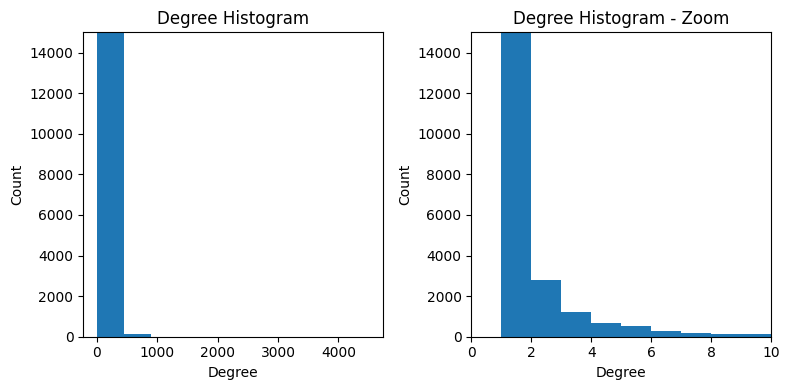

7368 nodes, 91058 edges
Nodes removed: 75.63%
Edges removed: 41.38%
Edges per nodes: 4.10


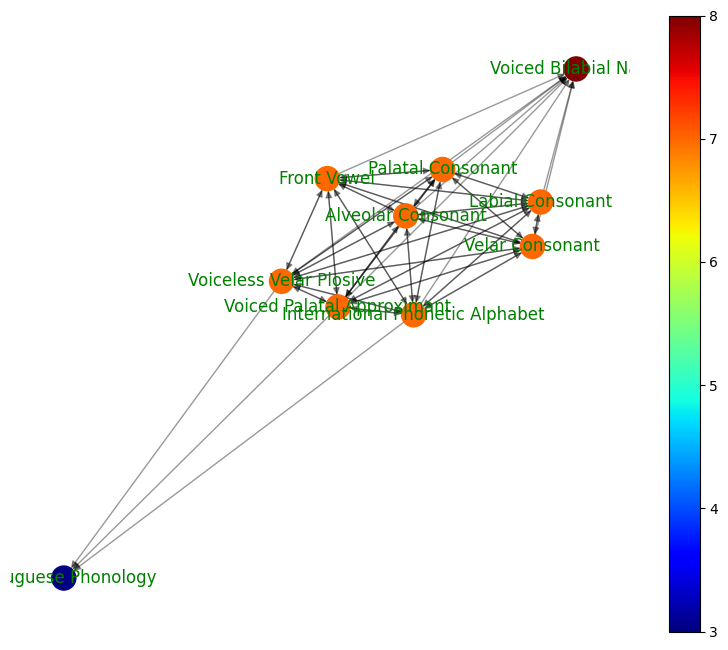

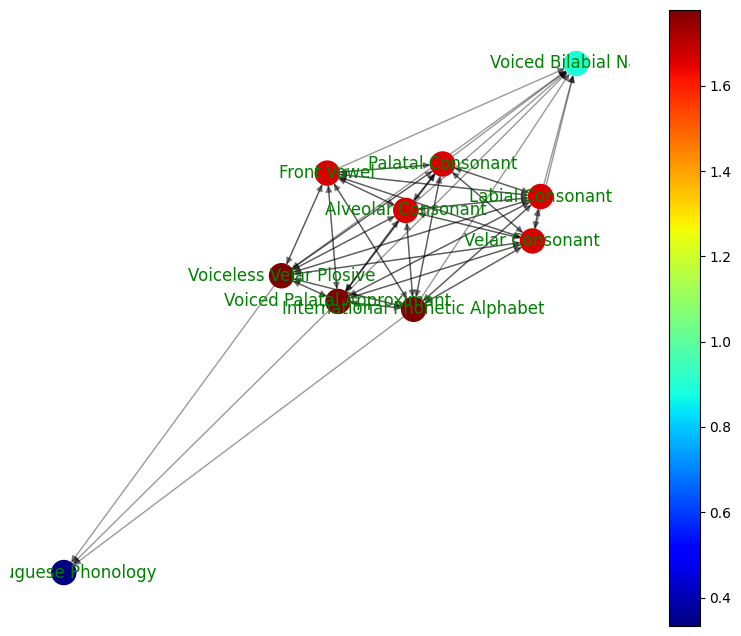

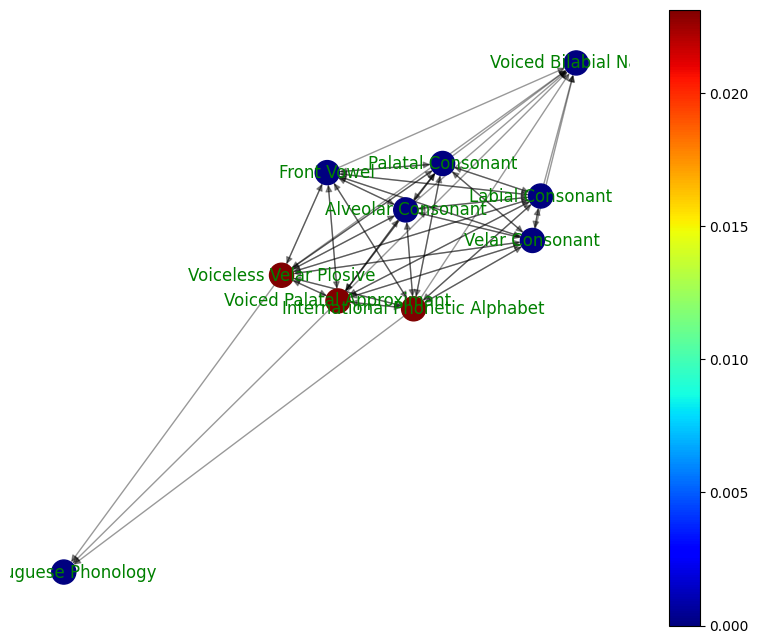

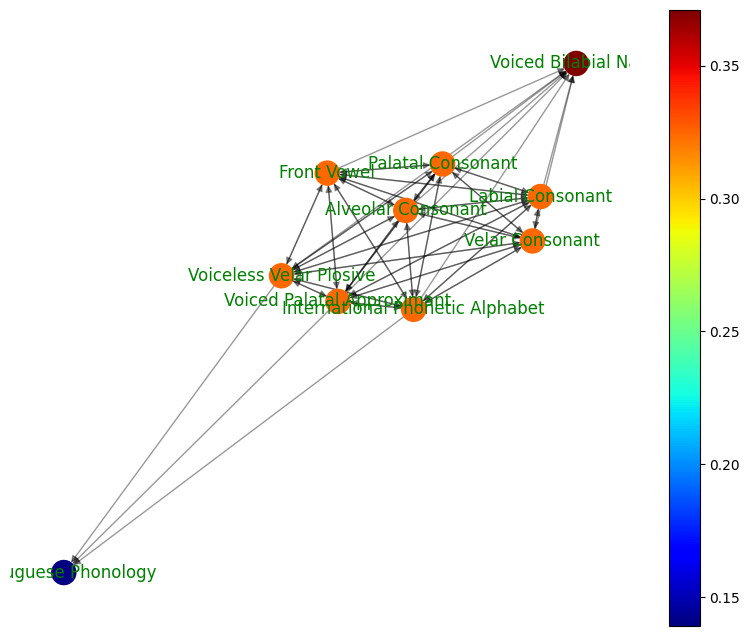

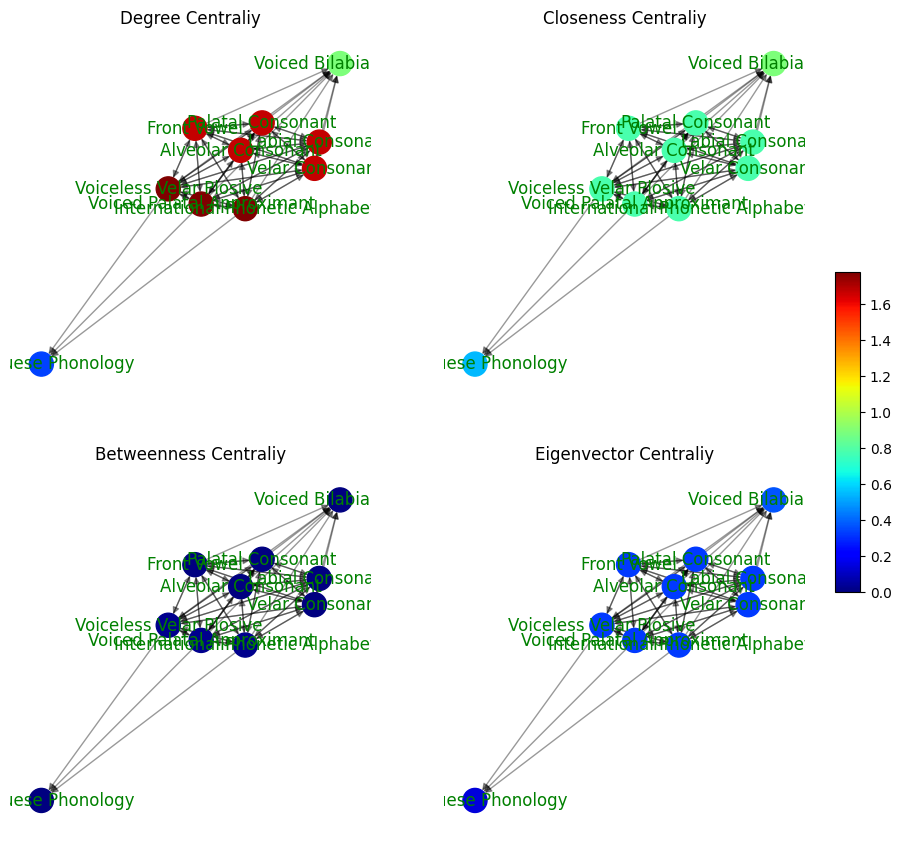

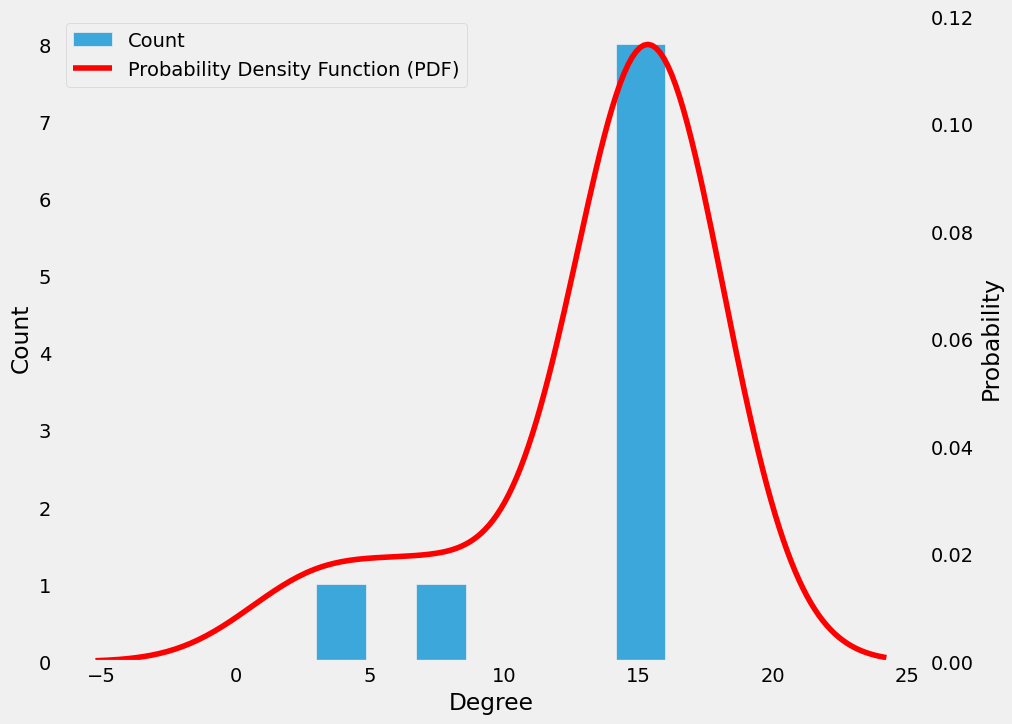

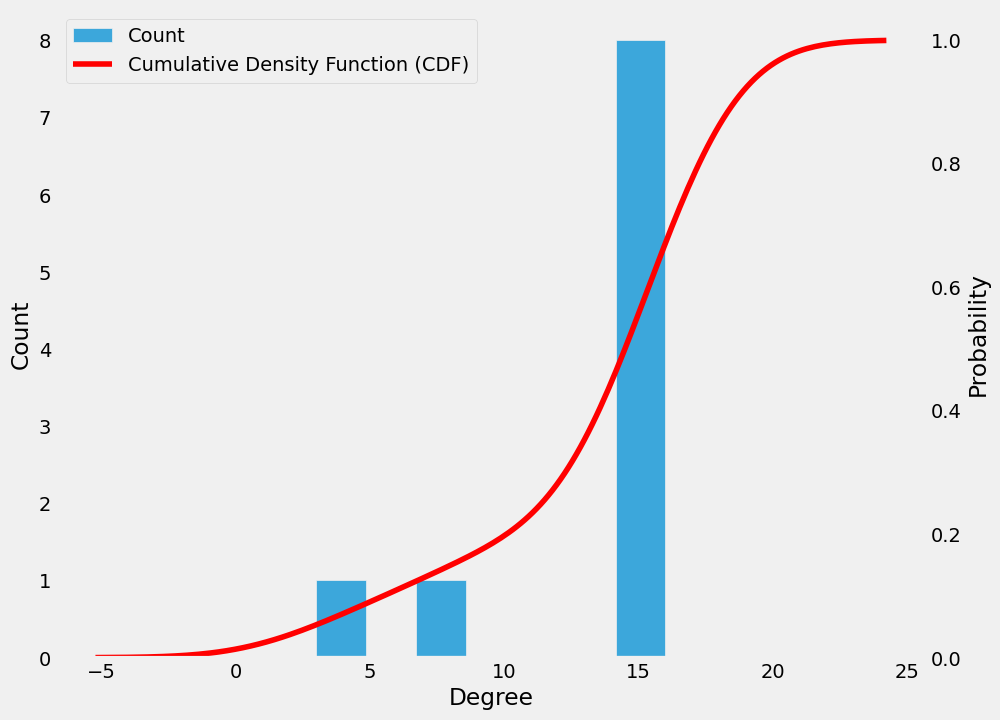

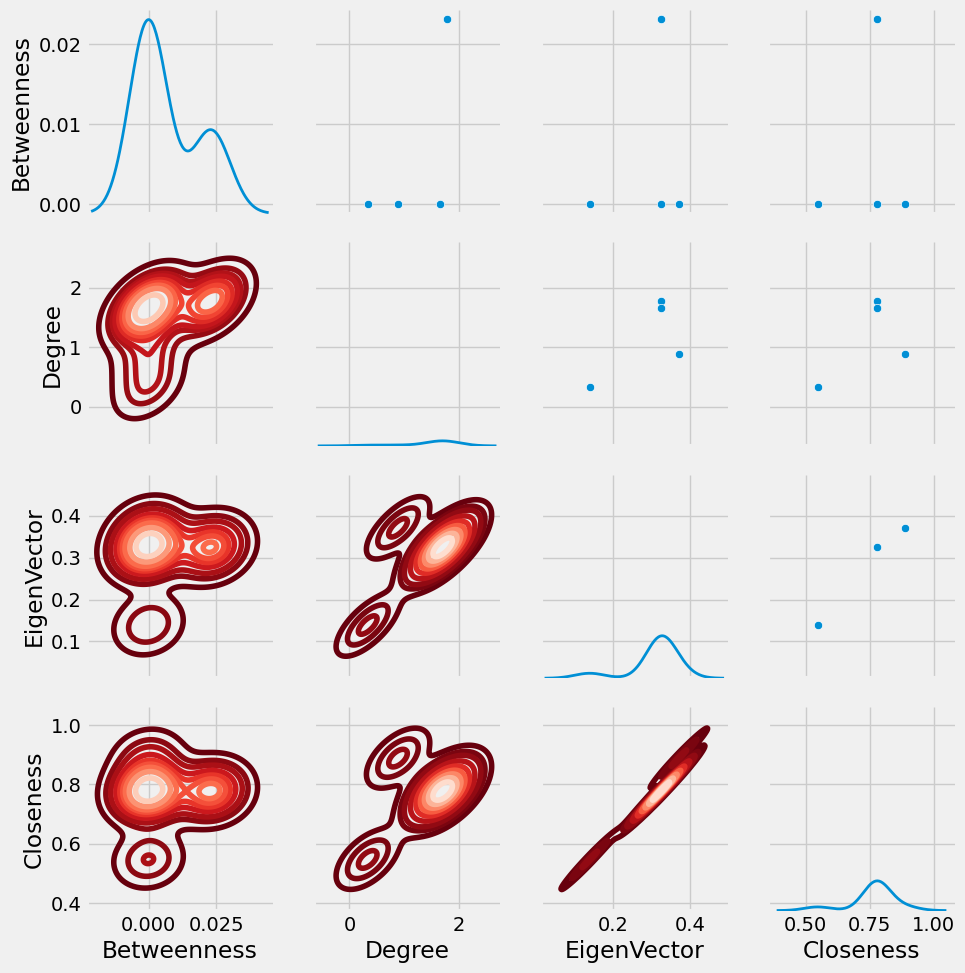

{8, 3, 14}


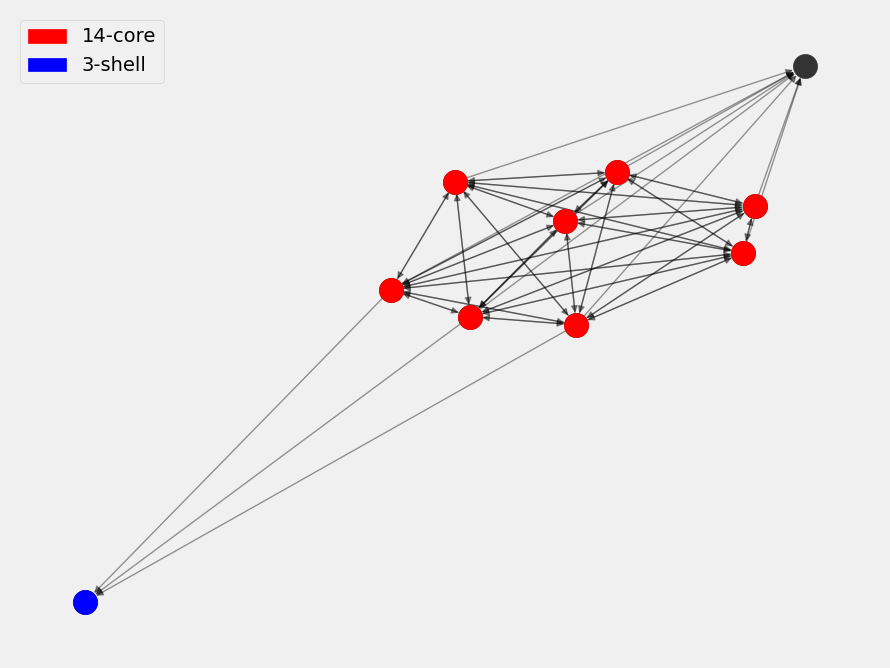

In [ ]:
composed = compose(create_graph, preprocessing, pruning, explore_network)
composed(args)